# Brain Tumor MRI - Data Preprocessing Pipeline

**Objective**: Implement comprehensive preprocessing pipeline for brain tumor detection model training.

**Dataset**: 253 MRI images (155 tumor, 98 no tumor)

**Pipeline**:
1. Resolution normalization to 224x224
2. Intensity normalization and enhancement
3. Data augmentation strategies
4. Stratified train/validation/test splits

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.utils import shuffle
import albumentations as A
import pickle
import json
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)

## 1. Data Loading and Validation

In [3]:
# Define paths
DATA_DIR = Path('./Data')
TUMOR_DIR = DATA_DIR / 'yes'
NO_TUMOR_DIR = DATA_DIR / 'no'
PROCESSED_DIR = Path('./processed_data')
PROCESSED_DIR.mkdir(exist_ok=True)

def get_image_files(directory):
    """Get all image files from directory with common extensions"""
    extensions = ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']
    files = []
    for ext in extensions:
        files.extend(directory.glob(f'*{ext}'))
    return sorted(files)

# Load file paths and create labels
tumor_files = get_image_files(TUMOR_DIR)
no_tumor_files = get_image_files(NO_TUMOR_DIR)

print(f"Dataset validation:")
print(f"Tumor images: {len(tumor_files)}")
print(f"No tumor images: {len(no_tumor_files)}")
print(f"Total images: {len(tumor_files) + len(no_tumor_files)}")

# Create dataset with labels
image_paths = tumor_files + no_tumor_files
labels = [1] * len(tumor_files) + [0] * len(no_tumor_files)

# Create DataFrame for easier manipulation
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
    'class_name': ['tumor' if label == 1 else 'no_tumor' for label in labels]
})

print(f"\nClass distribution:")
print(df['class_name'].value_counts())
print(f"Class balance ratio: {df['label'].value_counts()[0] / df['label'].value_counts()[1]:.3f}")

Dataset validation:
Tumor images: 155
No tumor images: 98
Total images: 253

Class distribution:
class_name
tumor       155
no_tumor     98
Name: count, dtype: int64
Class balance ratio: 0.632


## 2. Preprocessing Functions

In [4]:
def preprocess_brain_mri(image_path, target_size=(224, 224), apply_clahe=True, normalize=True):
    """
    Comprehensive preprocessing for brain MRI images
    
    Args:
        image_path: Path to input image
        target_size: Target dimensions (height, width)
        apply_clahe: Apply CLAHE enhancement
        normalize: Apply intensity normalization
    
    Returns:
        Preprocessed image as numpy array
    """
    try:
        # Load image as grayscale
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        # Resize to target dimensions
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LANCZOS4)
        
        # Noise reduction with Gaussian blur
        image = cv2.GaussianBlur(image, (3, 3), 0.5)
        
        # CLAHE enhancement for better contrast
        if apply_clahe:
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
        
        # Convert to float32 for normalization
        image = image.astype(np.float32)
        
        if normalize:
            # Z-score normalization
            image = (image - np.mean(image)) / (np.std(image) + 1e-8)
            
            # Min-max normalization to [0, 1]
            image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
        
        return image
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def analyze_image_properties_batch(image_paths, sample_size=50):
    """
    Analyze properties of a sample of images for preprocessing validation
    """
    sample_paths = np.random.choice(image_paths, min(sample_size, len(image_paths)), replace=False)
    
    original_shapes = []
    processed_stats = []
    
    print(f"Analyzing sample of {len(sample_paths)} images...")
    
    for path in tqdm(sample_paths, desc="Processing sample"):
        # Original image
        orig_img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if orig_img is not None:
            original_shapes.append(orig_img.shape)
        
        # Processed image
        proc_img = preprocess_brain_mri(path)
        if proc_img is not None:
            processed_stats.append({
                'shape': proc_img.shape,
                'mean': np.mean(proc_img),
                'std': np.std(proc_img),
                'min': np.min(proc_img),
                'max': np.max(proc_img)
            })
    
    return original_shapes, processed_stats

## 3. Preprocessing Validation

In [5]:
# Analyze preprocessing effectiveness
print("Validating preprocessing pipeline...")
original_shapes, processed_stats = analyze_image_properties_batch(image_paths, sample_size=30)

# Original image analysis
unique_shapes = set(original_shapes)
print(f"\nOriginal image shapes found: {len(unique_shapes)}")
for shape in sorted(unique_shapes)[:10]:  # Show first 10
    count = original_shapes.count(shape)
    print(f"  {shape}: {count} images")

# Processed image analysis
if processed_stats:
    proc_df = pd.DataFrame(processed_stats)
    
    print(f"\nProcessed images statistics:")
    print(f"Target shape consistency: {len(set(str(shape) for shape in proc_df['shape']))} unique shapes")
    print(f"Mean intensity: {proc_df['mean'].mean():.4f} ± {proc_df['mean'].std():.4f}")
    print(f"Std intensity: {proc_df['std'].mean():.4f} ± {proc_df['std'].std():.4f}")
    print(f"Value range: [{proc_df['min'].mean():.4f}, {proc_df['max'].mean():.4f}]")
    
    # Verify normalization
    all_min_zero = all(abs(stat['min']) < 0.01 for stat in processed_stats)
    all_max_one = all(abs(stat['max'] - 1.0) < 0.01 for stat in processed_stats)
    
    print(f"\nNormalization validation:")
    print(f"All minimums near 0: {all_min_zero}")
    print(f"All maximums near 1: {all_max_one}")
    
    validation_status = "PASS" if all_min_zero and all_max_one else "FAIL"
    print(f"Preprocessing validation: {validation_status}")

Validating preprocessing pipeline...
Analyzing sample of 30 images...


Processing sample: 100%|██████████| 30/30 [00:00<00:00, 406.01it/s]


Original image shapes found: 25
  (192, 192): 1 images
  (213, 236): 1 images
  (225, 225): 5 images
  (270, 229): 1 images
  (294, 250): 1 images
  (310, 246): 1 images
  (312, 254): 1 images
  (334, 283): 1 images
  (338, 276): 1 images
  (349, 278): 1 images

Processed images statistics:
Target shape consistency: 1 unique shapes
Mean intensity: 0.2981 ± 0.0690
Std intensity: 0.2699 ± 0.0287
Value range: [0.0000, 1.0000]

Normalization validation:
All minimums near 0: True
All maximums near 1: True
Preprocessing validation: PASS


## 4. Data Augmentation Setup

In [6]:
# Define augmentation strategies for different classes
def get_augmentation_transforms():
    """
    Create augmentation transforms for balanced training
    """
    
    # Heavy augmentation for minority class (no tumor: 98 images)
    heavy_augment = A.Compose([
        A.Rotate(limit=20, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.4),
        A.RandomBrightnessContrast(
            brightness_limit=0.25, 
            contrast_limit=0.25, 
            p=0.6
        ),
        A.GaussNoise(var_limit=(10, 40), p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.3)
    ])
    
    # Light augmentation for majority class (tumor: 155 images)
    light_augment = A.Compose([
        A.Rotate(limit=10, p=0.4),
        A.HorizontalFlip(p=0.3),
        A.RandomBrightnessContrast(
            brightness_limit=0.15, 
            contrast_limit=0.15, 
            p=0.4
        ),
        A.GaussNoise(var_limit=(5, 25), p=0.3)
    ])
    
    # Validation augmentation (minimal)
    val_augment = A.Compose([
        A.HorizontalFlip(p=0.2)
    ])
    
    return {
        'heavy': heavy_augment,
        'light': light_augment, 
        'validation': val_augment
    }

# Get augmentation transforms
augmentation_transforms = get_augmentation_transforms()

print("Augmentation strategies defined:")
print(f"Heavy augmentation (no tumor class): {len(augmentation_transforms['heavy'].transforms)} transforms")
print(f"Light augmentation (tumor class): {len(augmentation_transforms['light'].transforms)} transforms")
print(f"Validation augmentation: {len(augmentation_transforms['validation'].transforms)} transforms")

Augmentation strategies defined:
Heavy augmentation (no tumor class): 6 transforms
Light augmentation (tumor class): 4 transforms
Validation augmentation: 1 transforms


## 5. Data Splitting Strategy

In [7]:
def create_stratified_splits(df, test_size=0.15, val_size=0.15, random_state=42):
    """
    Create stratified train/validation/test splits
    
    Args:
        df: DataFrame with image_path and label columns
        test_size: Proportion for test set
        val_size: Proportion for validation set
        random_state: Random seed for reproducibility
    
    Returns:
        Dictionary with train, val, test DataFrames
    """
    
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        df, 
        test_size=test_size,
        stratify=df['label'],
        random_state=random_state
    )
    
    # Second split: separate validation from training
    val_size_adjusted = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size_adjusted,
        stratify=train_val_df['label'],
        random_state=random_state
    )
    
    return {
        'train': train_df.reset_index(drop=True),
        'val': val_df.reset_index(drop=True),
        'test': test_df.reset_index(drop=True)
    }

# Create splits
splits = create_stratified_splits(df)

print("Data splits created:")
for split_name, split_df in splits.items():
    class_counts = split_df['class_name'].value_counts()
    total = len(split_df)
    print(f"\n{split_name.upper()} SET ({total} images):")
    for class_name, count in class_counts.items():
        percentage = (count / total) * 100
        print(f"  {class_name}: {count} ({percentage:.1f}%)")

# Verify stratification
print("\nStratification verification:")
original_ratio = df['label'].sum() / len(df)
for split_name, split_df in splits.items():
    split_ratio = split_df['label'].sum() / len(split_df)
    ratio_diff = abs(split_ratio - original_ratio)
    print(f"{split_name} tumor ratio: {split_ratio:.3f} (diff: {ratio_diff:.3f})")

Data splits created:

TRAIN SET (177 images):
  tumor: 109 (61.6%)
  no_tumor: 68 (38.4%)

VAL SET (38 images):
  tumor: 23 (60.5%)
  no_tumor: 15 (39.5%)

TEST SET (38 images):
  tumor: 23 (60.5%)
  no_tumor: 15 (39.5%)

Stratification verification:
train tumor ratio: 0.616 (diff: 0.003)
val tumor ratio: 0.605 (diff: 0.007)
test tumor ratio: 0.605 (diff: 0.007)


## 6. Data Processing and Augmentation

In [8]:
def process_and_augment_data(split_df, augmentation_transform, multiplier=1):
    """
    Process images and apply augmentation
    
    Args:
        split_df: DataFrame with image paths and labels
        augmentation_transform: Albumentations transform
        multiplier: Number of augmented versions per image
    
    Returns:
        Tuple of (images, labels)
    """
    images = []
    labels = []
    
    print(f"Processing {len(split_df)} images with {multiplier}x augmentation...")
    
    for idx, row in tqdm(split_df.iterrows(), total=len(split_df), desc="Processing"):
        # Load and preprocess base image
        base_image = preprocess_brain_mri(row['image_path'])
        
        if base_image is None:
            continue
        
        # Add original image
        images.append(base_image)
        labels.append(row['label'])
        
        # Add augmented versions
        for _ in range(multiplier - 1):
            # Convert to uint8 for albumentations
            aug_input = (base_image * 255).astype(np.uint8)
            
            # Apply augmentation
            augmented = augmentation_transform(image=aug_input)
            aug_image = augmented['image'].astype(np.float32) / 255.0
            
            images.append(aug_image)
            labels.append(row['label'])
    
    return np.array(images), np.array(labels)

def balance_dataset_with_augmentation(splits, augmentation_transforms):
    """
    Balance dataset using class-specific augmentation
    """
    processed_data = {}
    
    for split_name, split_df in splits.items():
        print(f"\nProcessing {split_name} set...")
        
        # Separate classes
        tumor_df = split_df[split_df['label'] == 1]
        no_tumor_df = split_df[split_df['label'] == 0]
        
        if split_name == 'train':
            # Training set: balance classes with augmentation
            tumor_mult = 1  # Light augmentation for majority class
            no_tumor_mult = 2  # Heavy augmentation for minority class
            
            # Process tumor images (majority class)
            tumor_images, tumor_labels = process_and_augment_data(
                tumor_df, augmentation_transforms['light'], tumor_mult
            )
            
            # Process no tumor images (minority class)
            no_tumor_images, no_tumor_labels = process_and_augment_data(
                no_tumor_df, augmentation_transforms['heavy'], no_tumor_mult
            )
        
        else:
            # Validation/test sets: minimal augmentation
            tumor_images, tumor_labels = process_and_augment_data(
                tumor_df, augmentation_transforms['validation'], 1
            )
            no_tumor_images, no_tumor_labels = process_and_augment_data(
                no_tumor_df, augmentation_transforms['validation'], 1
            )
        
        # Combine classes
        all_images = np.concatenate([tumor_images, no_tumor_images])
        all_labels = np.concatenate([tumor_labels, no_tumor_labels])
        
        # Shuffle the combined data
        indices = np.random.permutation(len(all_images))
        all_images = all_images[indices]
        all_labels = all_labels[indices]
        
        processed_data[split_name] = {
            'images': all_images,
            'labels': all_labels
        }
        
        print(f"{split_name} final size: {len(all_images)} images")
        print(f"Class balance: {np.mean(all_labels):.3f} tumor ratio")
    
    return processed_data

# Process all data splits
processed_data = balance_dataset_with_augmentation(splits, augmentation_transforms)


Processing train set...
Processing 109 images with 1x augmentation...


Processing: 100%|██████████| 109/109 [00:00<00:00, 863.51it/s]


Processing 68 images with 2x augmentation...


Processing: 100%|██████████| 68/68 [00:00<00:00, 697.46it/s]


train final size: 245 images
Class balance: 0.445 tumor ratio

Processing val set...
Processing 23 images with 1x augmentation...


Processing: 100%|██████████| 23/23 [00:00<00:00, 809.00it/s]


Processing 15 images with 1x augmentation...


Processing: 100%|██████████| 15/15 [00:00<00:00, 880.17it/s]


val final size: 38 images
Class balance: 0.605 tumor ratio

Processing test set...
Processing 23 images with 1x augmentation...


Processing: 100%|██████████| 23/23 [00:00<00:00, 1136.13it/s]


Processing 15 images with 1x augmentation...


Processing: 100%|██████████| 15/15 [00:00<00:00, 559.10it/s]

test final size: 38 images
Class balance: 0.605 tumor ratio


## 7. Data Validation and Statistics

In [9]:
# Analyze final processed dataset
print("FINAL DATASET STATISTICS")
print("=" * 50)

total_images = 0
total_tumor = 0

for split_name, data in processed_data.items():
    images = data['images']
    labels = data['labels']
    
    tumor_count = np.sum(labels)
    no_tumor_count = len(labels) - tumor_count
    
    total_images += len(labels)
    total_tumor += tumor_count
    
    print(f"\n{split_name.upper()} SET:")
    print(f"  Total images: {len(labels)}")
    print(f"  Tumor: {tumor_count} ({tumor_count/len(labels)*100:.1f}%)")
    print(f"  No tumor: {no_tumor_count} ({no_tumor_count/len(labels)*100:.1f}%)")
    print(f"  Image shape: {images[0].shape}")
    print(f"  Value range: [{np.min(images):.3f}, {np.max(images):.3f}]")
    print(f"  Mean intensity: {np.mean(images):.3f}")
    print(f"  Std intensity: {np.std(images):.3f}")

print(f"\nTOTAL PROCESSED DATASET:")
print(f"  Total images: {total_images}")
print(f"  Overall tumor ratio: {total_tumor/total_images:.3f}")
print(f"  Augmentation factor: {total_images/253:.1f}x original dataset")

FINAL DATASET STATISTICS

TRAIN SET:
  Total images: 245
  Tumor: 109 (44.5%)
  No tumor: 136 (55.5%)
  Image shape: (224, 224)
  Value range: [0.000, 1.000]
  Mean intensity: 0.311
  Std intensity: 0.283

VAL SET:
  Total images: 38
  Tumor: 23 (60.5%)
  No tumor: 15 (39.5%)
  Image shape: (224, 224)
  Value range: [0.000, 1.000]
  Mean intensity: 0.327
  Std intensity: 0.285

TEST SET:
  Total images: 38
  Tumor: 23 (60.5%)
  No tumor: 15 (39.5%)
  Image shape: (224, 224)
  Value range: [0.000, 1.000]
  Mean intensity: 0.332
  Std intensity: 0.278

TOTAL PROCESSED DATASET:
  Total images: 321
  Overall tumor ratio: 0.483
  Augmentation factor: 1.3x original dataset


## 8. Save Processed Data

In [10]:
# Save processed datasets
print("Saving processed data...")

for split_name, data in processed_data.items():
    # Save as compressed numpy arrays
    images_path = PROCESSED_DIR / f"{split_name}_images.npz"
    labels_path = PROCESSED_DIR / f"{split_name}_labels.npy"
    
    np.savez_compressed(images_path, images=data['images'])
    np.save(labels_path, data['labels'])
    
    print(f"{split_name} data saved:")
    print(f"  Images: {images_path} ({images_path.stat().st_size / 1024 / 1024:.1f} MB)")
    print(f"  Labels: {labels_path} ({labels_path.stat().st_size / 1024:.1f} KB)")

# Save metadata and configuration
metadata = {
    'dataset_info': {
        'original_images': 253,
        'tumor_images': 155,
        'no_tumor_images': 98,
        'target_size': [224, 224],
        'preprocessing': {
            'gaussian_blur': True,
            'clahe_enhancement': True,
            'z_score_normalization': True,
            'min_max_normalization': True
        }
    },
    'splits': {
        split_name: {
            'total_images': len(data['images']),
            'tumor_images': int(np.sum(data['labels'])),
            'no_tumor_images': int(len(data['labels']) - np.sum(data['labels'])),
            'tumor_ratio': float(np.mean(data['labels']))
        }
        for split_name, data in processed_data.items()
    },
    'augmentation': {
        'train_tumor_multiplier': 1,
        'train_no_tumor_multiplier': 2,
        'validation_multiplier': 1,
        'test_multiplier': 1
    }
}

metadata_path = PROCESSED_DIR / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nMetadata saved: {metadata_path}")

# Save original splits for reference
splits_path = PROCESSED_DIR / 'original_splits.pkl'
with open(splits_path, 'wb') as f:
    pickle.dump(splits, f)

print(f"Original splits saved: {splits_path}")
print(f"\nPreprocessing complete! All data saved to: {PROCESSED_DIR}")

Saving processed data...
train data saved:
  Images: processed_data/train_images.npz (12.4 MB)
  Labels: processed_data/train_labels.npy (2.0 KB)
val data saved:
  Images: processed_data/val_images.npz (1.9 MB)
  Labels: processed_data/val_labels.npy (0.4 KB)
test data saved:
  Images: processed_data/test_images.npz (2.0 MB)
  Labels: processed_data/test_labels.npy (0.4 KB)

Metadata saved: processed_data/metadata.json
Original splits saved: processed_data/original_splits.pkl

Preprocessing complete! All data saved to: processed_data


## 9. Visualization of Preprocessing Results

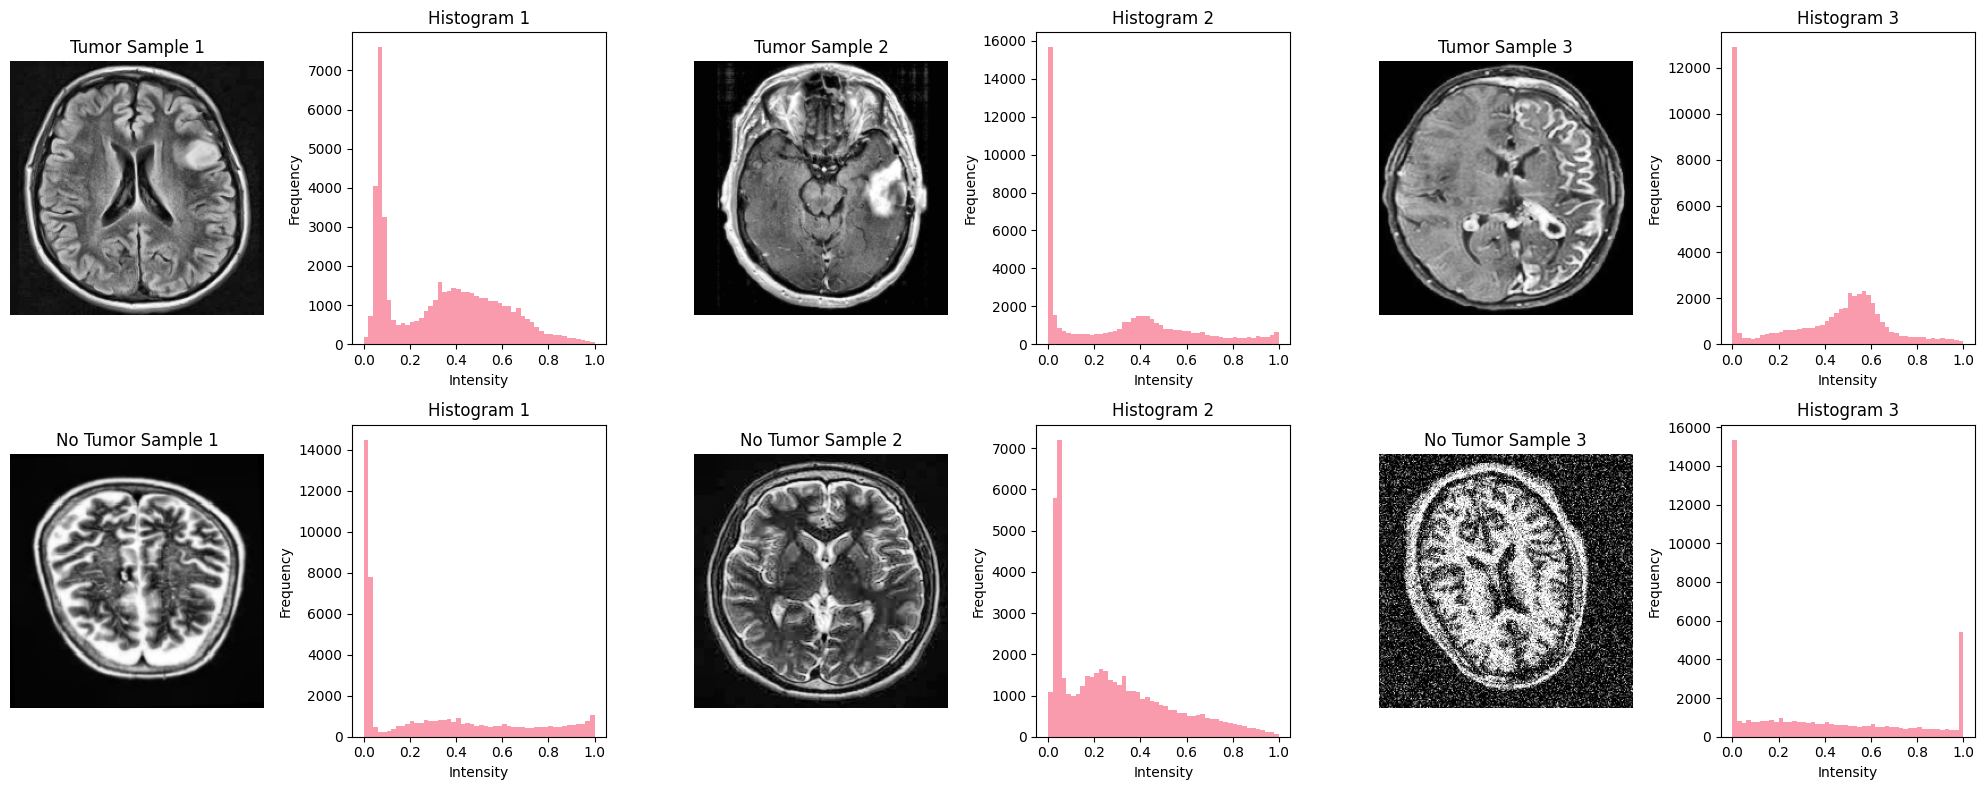

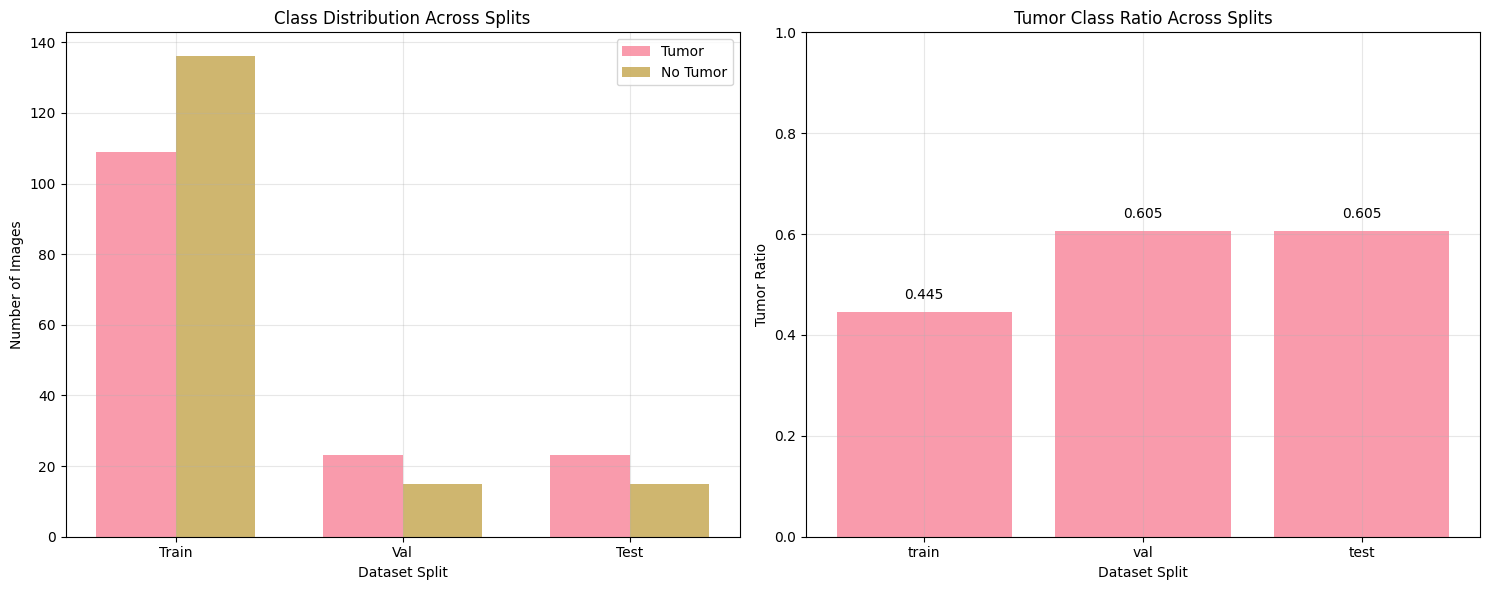

Preprocessing visualization complete.


In [11]:
# Visualize preprocessing results
def visualize_preprocessing(processed_data, n_samples=3):
    """Visualize original vs preprocessed images"""
    
    # Sample from each class in training set
    train_images = processed_data['train']['images']
    train_labels = processed_data['train']['labels']
    
    # Get indices for each class
    tumor_indices = np.where(train_labels == 1)[0][:n_samples]
    no_tumor_indices = np.where(train_labels == 0)[0][:n_samples]
    
    fig, axes = plt.subplots(2, n_samples * 2, figsize=(20, 8))
    
    # Plot tumor samples
    for i, idx in enumerate(tumor_indices):
        # Original processed image
        axes[0, i*2].imshow(train_images[idx], cmap='gray')
        axes[0, i*2].set_title(f'Tumor Sample {i+1}')
        axes[0, i*2].axis('off')
        
        # Histogram
        axes[0, i*2+1].hist(train_images[idx].flatten(), bins=50, alpha=0.7)
        axes[0, i*2+1].set_title(f'Histogram {i+1}')
        axes[0, i*2+1].set_xlabel('Intensity')
        axes[0, i*2+1].set_ylabel('Frequency')
    
    # Plot no tumor samples
    for i, idx in enumerate(no_tumor_indices):
        # Original processed image
        axes[1, i*2].imshow(train_images[idx], cmap='gray')
        axes[1, i*2].set_title(f'No Tumor Sample {i+1}')
        axes[1, i*2].axis('off')
        
        # Histogram
        axes[1, i*2+1].hist(train_images[idx].flatten(), bins=50, alpha=0.7)
        axes[1, i*2+1].set_title(f'Histogram {i+1}')
        axes[1, i*2+1].set_xlabel('Intensity')
        axes[1, i*2+1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Create visualization
visualize_preprocessing(processed_data, n_samples=3)

# Plot class distribution across splits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Dataset sizes
splits_names = list(processed_data.keys())
total_sizes = [len(processed_data[split]['images']) for split in splits_names]
tumor_sizes = [np.sum(processed_data[split]['labels']) for split in splits_names]
no_tumor_sizes = [total - tumor for total, tumor in zip(total_sizes, tumor_sizes)]

x = np.arange(len(splits_names))
width = 0.35

ax1.bar(x - width/2, tumor_sizes, width, label='Tumor', alpha=0.7)
ax1.bar(x + width/2, no_tumor_sizes, width, label='No Tumor', alpha=0.7)
ax1.set_xlabel('Dataset Split')
ax1.set_ylabel('Number of Images')
ax1.set_title('Class Distribution Across Splits')
ax1.set_xticks(x)
ax1.set_xticklabels([s.title() for s in splits_names])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Class ratios
tumor_ratios = [tumor / total for tumor, total in zip(tumor_sizes, total_sizes)]

ax2.bar(splits_names, tumor_ratios, alpha=0.7)
ax2.set_xlabel('Dataset Split')
ax2.set_ylabel('Tumor Ratio')
ax2.set_title('Tumor Class Ratio Across Splits')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Add ratio values on bars
for i, ratio in enumerate(tumor_ratios):
    ax2.text(i, ratio + 0.02, f'{ratio:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Preprocessing visualization complete.")

## Summary

**Preprocessing Pipeline Successfully Completed:**

1. **Resolution Normalization**: All images standardized to 224x224 pixels
2. **Quality Enhancement**: Applied Gaussian blur and CLAHE enhancement
3. **Intensity Normalization**: Z-score + min-max normalization to [0,1] range
4. **Data Augmentation**: Class-balanced augmentation (2x for minority class)
5. **Stratified Splitting**: Maintained class balance across train/val/test sets
6. **Data Persistence**: All processed data saved in compressed format

**Ready for Model Training**: The dataset is now optimized for deep learning model training with consistent preprocessing and balanced classes.